# Import important libraries

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Flatten, Dropout
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.utils import to_categorical
from keras.preprocessing import text, sequence

from wordcloud import WordCloud
from nltk.corpus import stopwords

import re

# Data Preparartion

In [4]:
#load the training and testing data
df_train = pd.read_table('Data/train.tsv', sep='\t')
df_test = pd.read_table('Data/test.tsv', sep='\t')

In [5]:
#Explore data
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [6]:
#check for missing data and drop the columns which doesn't make sense
df_train.dropna()
df_train = df_train.drop(['PhraseId','SentenceId'], axis=1)
df_train.reset_index(drop=True)

df_test.dropna()
df_test = df_test.drop(['PhraseId'], axis=1)
df_test.reset_index(drop=True)

,SentenceId,Phrase
0,8545,An intermittently pleasing but mostly routine ...
1,8545,An intermittently pleasing but mostly routine ...
2,8545,An
3,8545,intermittently pleasing but mostly routine effort
4,8545,intermittently pleasing but mostly routine
5,8545,intermittently pleasing but
6,8545,intermittently pleasing
7,8545,intermittently
8,8545,pleasing
9,8545,but


In [7]:
for i in range(5):
    print("Phrase #",i+1)
    print("Sentiment - ",df_train.Sentiment[i])
    print("Phrase - ",df_train.Phrase[i])
    print()

Phrase # 1
Sentiment -  1
Phrase -  A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .

Phrase # 2
Sentiment -  2
Phrase -  A series of escapades demonstrating the adage that what is good for the goose

Phrase # 3
Sentiment -  2
Phrase -  A series

Phrase # 4
Sentiment -  2
Phrase -  A

Phrase # 5
Sentiment -  2
Phrase -  series



In [8]:
#Data cleaning, removing stop words, punctuation etc
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [9]:
def clean_text(text, remove_stopwords = True):
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text,  
                  flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [10]:
# Clean the summaries and texts

clean_Phrase_train = []
for phrase in df_train.Phrase:
    clean_Phrase_train.append(clean_text(phrase, remove_stopwords=True))
print("Phrase cleaning complete.")

clean_Phrase_test = []
for phrase in df_test.Phrase:
    clean_Phrase_test.append(clean_text(phrase, remove_stopwords=True))
print("Phrase cleaning complete.")

Phrase cleaning complete.
Phrase cleaning complete.


In [12]:
# Data after cleaning
for i in range(5):
    print("Phrase #",i+1)
    print("Sentiment - ",df_train.Sentiment[i])
    print("Phrase - ",clean_Phrase_train[i])
    print()

Phrase # 1
Sentiment -  1
Phrase -  series escapades demonstrating adage good goose also good gander occasionally amuses none amounts much story

Phrase # 2
Sentiment -  2
Phrase -  series escapades demonstrating adage good goose

Phrase # 3
Sentiment -  2
Phrase -  series

Phrase # 4
Sentiment -  2
Phrase -  

Phrase # 5
Sentiment -  2
Phrase -  series



# Word Cloud

(-0.5, 499.5, 499.5, -0.5)

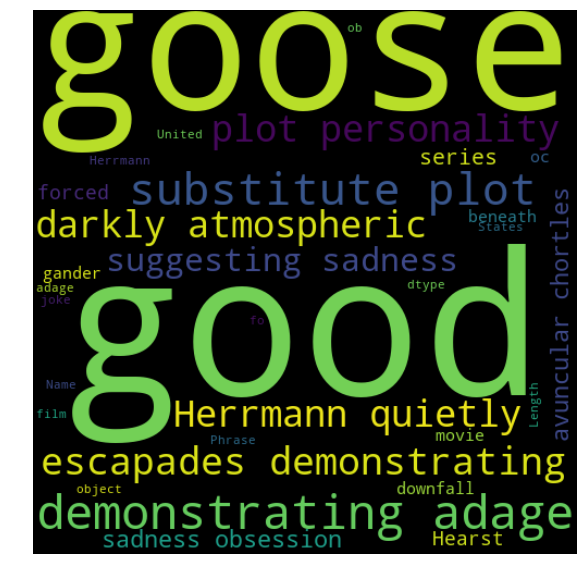

In [13]:
wordcloud = WordCloud(width=500, height=500, background_color='black',random_state=1).generate(str(df_train['Phrase']))
plt.figure(1, figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

In [14]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [15]:
y = df_train.Sentiment.value_counts()

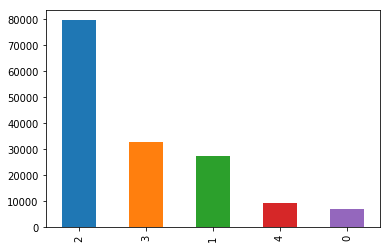

In [16]:
y.plot(kind='bar')

# Feature extraction

**Methods to be used<br>**
**1. CountVectorizer<br>**
**2. TfidfVectorizer<br>**
**3. WordEmbedding**

## 1) CountVectorizer

In [17]:
vect = CountVectorizer()

In [18]:
vect.fit(clean_Phrase_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [19]:
train_feature_cv = vect.transform(clean_Phrase_train)
test_feature_cv = vect.transform(clean_Phrase_test)

## 2) TfIdfVectorizer

In [20]:
tf = TfidfVectorizer()

In [21]:
tf.fit(clean_Phrase_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [22]:
train_feature_tf = tf.transform(clean_Phrase_train)
test_feature_tf = tf.transform(clean_Phrase_test)

## 3) Word Embedding

In [26]:
# Using pretrained Word Embedding - GloVe
#load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('/Users/sayedali/Documents/Self/New Projects/Text Summarization/glove.6B.50d.txt')):
    values = line.split()
    embeddings_index[values[0]] = numpy.asarray(values[1:], dtype='float32')

# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(clean_Phrase_train)
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(clean_Phrase_train), maxlen=70)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(clean_Phrase_test), maxlen=70)

# create token-embedding mapping
embedding_matrix = numpy.zeros((len(word_index) + 1, 50))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Model Building

# Naive Bayes

In [27]:
# Naive bayes using countVectorizer
naive = MultinomialNB()
naive.fit(train_feature_cv,df_train['Sentiment'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [28]:
naive_predict = naive.predict(test_feature_cv)

In [29]:
naive_predict

array([3, 3, 2, ..., 2, 2, 1])

In [30]:
len(df_test)

66292

In [33]:
subm = pd.read_csv('Data/sampleSubmission.csv')

In [34]:
y_test = subm['Sentiment']

In [35]:
count = 0
for i in range(len(y_test)):
    if y_test[i] == naive_predict[i]:
            count += 1
count

43563

In [36]:
print("Accuracy : ", count/len(y_test))

Accuracy :  0.6571381162131177


# Logistic Regression

In [37]:
#Logistic regression using TFIDF
log = LogisticRegression()
log.fit(train_feature_cv,df_train['Sentiment'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [38]:
log_predict = log.predict(test_feature_cv)

In [39]:
count = 0
for i in range(len(y_test)):
    if y_test[i] == log_predict[i]:
            count += 1
count

48286

In [40]:
print("Accuracy : ", count/len(y_test))

Accuracy :  0.7283835153563024


# Shallow Neural Network

In [56]:
model = Sequential()

#num_words = len(word_index) + 1

#input_shape = train_feature_cv.shape[1]
model.add(Dense(50,activation='relu', input_shape=(70,)))
model.add(Dropout(0.2))
model.add(Dense(5,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 50)                3550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 255       
Total params: 3,805
Trainable params: 3,805
Non-trainable params: 0
_________________________________________________________________
None


In [57]:
y_train = to_categorical(df_train['Sentiment'])

In [58]:
model.fit(train_seq_x,y_train, epochs=10, batch_size=1000)

Epoch 1/10
156060/156060 [==============================] - 4s 26us/step - loss: 8.1165 - acc: 0.4930
Epoch 2/10
156060/156060 [==============================] - 2s 15us/step - loss: 7.8838 - acc: 0.5085
Epoch 3/10
156060/156060 [==============================] - 3s 17us/step - loss: 7.8784 - acc: 0.5083
Epoch 4/10
156060/156060 [==============================] - 3s 18us/step - loss: 7.8580 - acc: 0.5095
Epoch 5/10
156060/156060 [==============================] - 3s 18us/step - loss: 7.8505 - acc: 0.5097
Epoch 6/10
156060/156060 [==============================] - 3s 19us/step - loss: 7.8632 - acc: 0.5078
Epoch 7/10
156060/156060 [==============================] - 3s 20us/step - loss: 7.8540 - acc: 0.5095
Epoch 8/10
156060/156060 [==============================] - 3s 19us/step - loss: 7.8291 - acc: 0.5109
Epoch 9/10
156060/156060 [==============================] - 3s 19us/step - loss: 7.8189 - acc: 0.5112
Epoch 10/10
156060/156060 [==============================] - 3s 19us/step - loss: 

In [59]:
y_pred_nn = model.predict(x=valid_seq_x)

In [60]:
y = y_pred_nn.argmax(1)

In [61]:
count = 0
for i in range(len(y_pred_nn)):
    if y_test[i] == y[i]:
            count += 1
count

62994

In [62]:
print("Accuracy : ", count/len(y_pred_nn))

Accuracy :  0.9502504072889639


# Deep Learning Model

## Learn Word Embedding : while training the network 

In [63]:
EMBEDDING_DIM = 50
model_dl = Sequential()

vocab_size = len(word_index) + 1
model_dl.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=70))
model_dl.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2))
model_dl.add(Dense(5, activation='softmax'))

model_dl.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
print(model_dl.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 70, 50)            757250    
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                7968      
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 165       
Total params: 765,383
Trainable params: 765,383
Non-trainable params: 0
_________________________________________________________________
None


In [64]:
print('Train......')
model.fit(train_seq_x,y_train,epochs=10,batch_size=2000,verbose=2)

Train......
Epoch 1/10
 - 2s - loss: 7.8083 - acc: 0.5091
Epoch 2/10
 - 2s - loss: 7.7922 - acc: 0.5079
Epoch 3/10
 - 2s - loss: 7.7979 - acc: 0.5055
Epoch 4/10
 - 2s - loss: 7.7806 - acc: 0.5062
Epoch 5/10
 - 2s - loss: 7.7519 - acc: 0.5076
Epoch 6/10
 - 2s - loss: 7.6735 - acc: 0.5012
Epoch 7/10
 - 2s - loss: 7.3139 - acc: 0.4664
Epoch 8/10
 - 2s - loss: 6.8199 - acc: 0.4351
Epoch 9/10
 - 2s - loss: 6.0715 - acc: 0.4126
Epoch 10/10
 - 2s - loss: 5.5668 - acc: 0.5045


In [65]:
y_pred_dl = model.predict(valid_seq_x)

In [66]:
y = y_pred_dl.argmax(1)

In [67]:
count = 0
for i in range(len(y_pred_nn)):
    if y_test[i] == y[i]:
            count += 1
count

61904

In [68]:
print("Accuracy : ", count/len(y_pred_dl))

Accuracy :  0.9338080009654257


**The sentiment labels are:<br>**

0 - negative<br>
1 - somewhat negative<br>
2 - neutral<br>
3 - somewhat positive<br>
4 - positive

In [81]:
#Let us test some examples
test_sample_1 = "Maybe I like this movie"
test_sample_2 = "This movie is fantastic"
test_sample_3 = "Not to my taste"
test_sample_4 = "bad Movie"
test_sample_5 = "I don't like an action"
test_sample_6 = "This movie really sucks"
test_sample_7 = "Good Movie"
test_sample_8 = "Not a good movie"

test_sample = [test_sample_1,
               test_sample_2,
               test_sample_3,
               test_sample_4,
               test_sample_5,
               test_sample_6,
               test_sample_7,
               test_sample_8
              ]

token = text.Tokenizer()
token.fit_on_texts(test_sample)
word_index = token.word_index

test_sample_seq = sequence.pad_sequences(token.texts_to_sequences(test_sample), maxlen=70)

#Prediction
model_dl.predict(test_sample_seq).argmax(1)

array([3, 4, 4, 3, 3, 0, 3, 2])